# PySpark Internals: Architecture, Execution, and Optimization

This notebook provides an in-depth look at PySpark's internal workings, including:

1. Spark Architecture Overview
2. Executors and Resource Management
3. Task Slots and Parallelism
4. Lazy Execution and DAG Optimization
5. Memory Management
6. Data Shuffling and Partitioning
7. Performance Tuning

Throughout this tutorial, we'll combine theory with practical demonstrations to help you understand how Spark works under the hood.

In [1]:
# Initialize Spark Session with specific configurations for demonstration
from pyspark.sql import SparkSession
from pyspark import SparkConf
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql.functions import col, explode, lit, udf
from pyspark.sql.types import IntegerType, StringType, StructType, StructField

# Create a configuration with explicit executor settings for illustration
conf = SparkConf() \
    .set("spark.executor.instances", "2") \
    .set("spark.executor.cores", "2") \
    .set("spark.executor.memory", "1g") \
    .set("spark.default.parallelism", "4") \
    .set("spark.sql.shuffle.partitions", "4")

# Initialize SparkSession with our configuration
spark = SparkSession.builder \
    .appName("PySpark Internals Tutorial") \
    .config(conf=conf) \
    .getOrCreate()

# When running in local mode, some of these settings might be overridden
print("Spark version:", spark.version)
print("\nActive Spark Configuration:")
for item in sorted(spark.sparkContext.getConf().getAll()):
    print(" - ", item[0], ":", item[1])

/opt/spark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/18 07:26:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark version: 3.5.1

Active Spark Configuration:
 -  spark.app.id : local-1744961166506
 -  spark.app.name : PySpark Internals Tutorial
 -  spark.app.startTime : 1744961166120
 -  spark.app.submitTime : 1744961166054
 -  spark.default.parallelism : 4
 -  spark.driver.extraJavaOptions : -Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens

## 1. Spark Architecture Overview

Apache Spark has a distributed architecture consisting of:

1. **Driver**: The central coordinator that:
   - Runs your main program
   - Analyzes, distributes, and schedules work across executors
   - Maintains information about the Spark application
   - Responds to user program or input
   - Distributes work to executors

2. **Executors**: Worker nodes that:
   - Run the tasks assigned by the driver
   - Store computation results in memory or disk
   - Return results to the driver

3. **Cluster Manager**: External service for acquiring resources (e.g., YARN, Mesos, Kubernetes, or Spark's standalone manager)

Here's a simplified diagram of this architecture:

```
+------------------+     +----------------+
|                  |     |                |
|  Driver Program  |     | Cluster        |
|  (SparkContext) |<--->| Manager        |
|                  |     |                |
+------------------+     +----------------+
         |                       |
         v                       v
+------------------+     +------------------+
|                  |     |                  |
|    Executor 1    |     |    Executor N    |
| +---+ +---+ +---+|     | +---+ +---+ +---+|
| |T1 | |T2 | |T3 ||     | |T1 | |T2 | |T3 ||
| +---+ +---+ +---+|     | +---+ +---+ +---+|
|                  |     |                  |
| (Cache)  (Cache) |     | (Cache)  (Cache) |
+------------------+     +------------------+
```

In local mode (which we're using in this notebook), all these components run within the same JVM process.

## 2. Executors and Resource Management

Executors are worker processes responsible for running individual tasks for a Spark application. They're launched at the beginning of a Spark application and typically run for the entire lifetime of the application.

Key executor configurations:

- **spark.executor.instances**: Total number of executors requested
- **spark.executor.cores**: Number of CPU cores allocated to each executor (also determines max tasks per executor)
- **spark.executor.memory**: Amount of memory allocated to each executor
- **spark.executor.memoryOverhead**: Additional memory overhead (default is 10% of executor memory)

Let's look at our current configuration:

In [2]:
# Get executor-related configurations
executor_configs = [
    "spark.executor.instances",
    "spark.executor.cores",
    "spark.executor.memory",
    "spark.executor.memoryOverhead",
    "spark.driver.memory",
    "spark.driver.cores"
]

print("Current Executor Configuration:")
for config in executor_configs:
    value = spark.conf.get(config, "Not explicitly set")
    print(f"{config}: {value}")

# In local mode, we can also see the actual cores available
print(f"\nAvailable cores: {spark.sparkContext.defaultParallelism}")

Current Executor Configuration:
spark.executor.instances: 2
spark.executor.cores: 2
spark.executor.memory: 1g
spark.executor.memoryOverhead: Not explicitly set
spark.driver.memory: Not explicitly set
spark.driver.cores: Not explicitly set

Available cores: 4


### Executor Memory Breakdown

Each executor's memory is divided into several regions:

1. **Reserved Memory**: (~300MB) System reservation
2. **User Memory**: (~40%) For user-defined data structures and Spark internal metadata
3. **Execution Memory**: (~60%) For computation (joins, aggregations, shuffles)
4. **Storage Memory**: Shared with execution memory, adjusts dynamically

```
+--------------------+ ------------------
|  Reserved Memory   |     (~300MB)
+--------------------+ ------------------
|                    |
|    User Memory     |     (~40%)
|                    |
+--------------------+ ------------------
|                    |
|   Execution and    |
|  Storage Memory    |     (~60%)
|  (Dynamic Sharing) |
|                    |
+--------------------+ ------------------
```

This memory management is controlled by configurations such as:
- `spark.memory.fraction`: Fraction of heap used for execution and storage (default 0.6)
- `spark.memory.storageFraction`: Amount of execution memory that can be claimed by storage (default 0.5)

## 3. Task Slots and Parallelism

Spark divides work into **tasks** that are executed in parallel across executor cores. Let's understand how parallelism works in Spark:

### Key Concepts:

- **Task**: The smallest unit of execution in Spark
- **Task Slot**: A place where a task can execute (basically a CPU core in an executor)
- **Partition**: A chunk of data processed by a single task

### Determining Parallelism:

The total number of parallel tasks that can run is determined by:
```
Total Task Slots = Number of Executors × Cores per Executor
```

Let's demonstrate how parallelism affects execution by creating datasets with different numbers of partitions:

Partitions: 1, Duration: 1.35 seconds
Partitions: 2, Duration: 0.72 seconds
Partitions: 4, Duration: 0.36 seconds
Partitions: 8, Duration: 0.25 seconds
Partitions: 16, Duration: 0.25 seconds


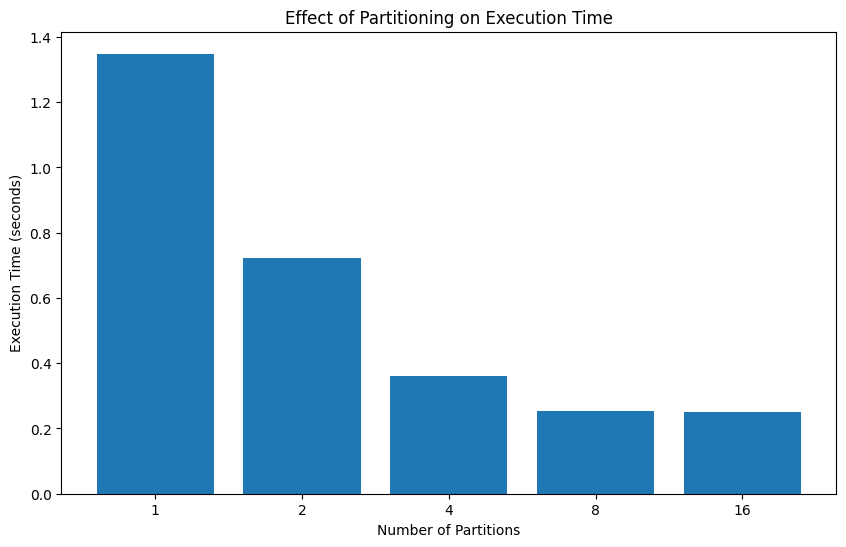

In [3]:
# Create a large-ish dataset
def create_test_df(num_partitions):
    # Create data with 1 million rows
    data = spark.range(0, 1000000, 1, num_partitions)
    return data

# Function to benchmark operations with different partitioning
def benchmark_partitions(partition_counts):
    results = []
    
    for partitions in partition_counts:
        # Create dataset with specified partitions
        df = create_test_df(partitions)
        
        # Force a shuffle operation
        start_time = time.time()
        count = df.repartition(partitions).groupBy(df.id % 100).count().collect()
        duration = time.time() - start_time
        
        results.append((partitions, duration))
        print(f"Partitions: {partitions}, Duration: {duration:.2f} seconds")
    
    return results

# Test with different partition counts
partition_counts = [1, 2, 4, 8, 16]
benchmark_results = benchmark_partitions(partition_counts)

# Plot results
partitions, durations = zip(*benchmark_results)
plt.figure(figsize=(10, 6))
plt.bar(range(len(partitions)), durations, tick_label=partitions)
plt.xlabel('Number of Partitions')
plt.ylabel('Execution Time (seconds)')
plt.title('Effect of Partitioning on Execution Time')
plt.show()

### Understanding the Results:

- With **too few partitions**, we don't fully utilize all available cores
- With **too many partitions**, we introduce overhead from task scheduling and management
- The **optimal number** is typically a small multiple of your total available cores

For maximum parallelism, you need at least as many partitions as you have task slots (cores across executors). However, having 2-3x more partitions than cores often yields better performance due to better work distribution.

## 4. Lazy Execution and DAG Optimization

One of Spark's most powerful features is its lazy execution model. When you define transformations on DataFrames or RDDs, Spark doesn't execute them immediately. Instead, it builds a **Directed Acyclic Graph (DAG)** of operations that will only be executed when an action is triggered.

### Transformations vs. Actions

- **Transformations**: Operations that create a new DataFrame/RDD without executing computation (e.g., `select()`, `filter()`, `map()`)
- **Actions**: Operations that trigger computation and return results (e.g., `count()`, `collect()`, `save()`)

Let's demonstrate this concept:

In [4]:
# Create a simple DataFrame
df = spark.range(0, 1000000)

# Define a sequence of transformations
# Note: No computation happens at this point
df_transformed = df \
    .filter(col("id") % 2 == 0) \
    .select(col("id"), col("id") * 2) \
    .withColumnRenamed("(id * 2)", "doubled")

print("DataFrame transformations defined, but not yet executed.")
print(f"Input DataFrame: {df}")
print(f"Transformed DataFrame: {df_transformed}")

# Let's look at the execution plan before execution
print("\nPhysical plan (this shows what WILL happen, but hasn't happened yet):")
df_transformed.explain()

# Now trigger an action
start_time = time.time()
result_count = df_transformed.count()  # This triggers execution
duration = time.time() - start_time

print(f"\nAction executed in {duration:.2f} seconds")
print(f"Result count: {result_count}")

# Trigger another action - notice it will be computed again
start_time = time.time()
first_rows = df_transformed.limit(5).collect()  # Another action
duration = time.time() - start_time

print(f"\nSecond action executed in {duration:.2f} seconds")
print("First 5 rows:")
for row in first_rows:
    print(row)

DataFrame transformations defined, but not yet executed.
Input DataFrame: DataFrame[id: bigint]
Transformed DataFrame: DataFrame[id: bigint, doubled: bigint]

Physical plan (this shows what WILL happen, but hasn't happened yet):
== Physical Plan ==
*(1) Project [id#65L, (id#65L * 2) AS doubled#72L]
+- *(1) Filter ((id#65L % 2) = 0)
   +- *(1) Range (0, 1000000, step=1, splits=4)



Action executed in 0.10 seconds
Result count: 500000

Second action executed in 0.04 seconds
First 5 rows:
Row(id=0, doubled=0)
Row(id=2, doubled=4)
Row(id=4, doubled=8)
Row(id=6, doubled=12)
Row(id=8, doubled=16)


### DAG Optimization

Spark's **Catalyst Optimizer** analyzes your logical plan and converts it to an optimized physical execution plan. Key optimizations include:

1. **Predicate Pushdown**: Filters are pushed down to the data source level
2. **Column Pruning**: Only required columns are read
3. **Operation Combining**: Multiple operations are combined when possible
4. **Constant Folding**: Expressions with constants are pre-computed

Let's see a more complex example with the optimization plan:

In [5]:
# Create a couple of DataFrames
employees = spark.createDataFrame([
    (1, "John", "Doe", 100),
    (2, "Jane", "Smith", 200),
    (3, "Bob", "Jones", 300),
    (4, "Alice", "Johnson", 200),
    (5, "Charlie", "Brown", 100),
    (6, "Eve", "Davis", 400)
], ["id", "first_name", "last_name", "dept_id"])

departments = spark.createDataFrame([
    (100, "HR", "New York"),
    (200, "Engineering", "San Francisco"),
    (300, "Marketing", "Chicago"),
    (400, "Sales", "Boston")
], ["dept_id", "dept_name", "location"])

# Define a complex transformation
result = employees \
    .join(departments, "dept_id") \
    .filter(col("location").isin("San Francisco", "New York")) \
    .filter(col("id") > 1) \
    .select("id", "first_name", "last_name", "dept_name")

# Let's look at the logical and physical plans
print("Logical Plan:")
result.explain(True)

# Execute
print("\nResult:")
result.show()

Logical Plan:
== Parsed Logical Plan ==
'Project ['id, 'first_name, 'last_name, 'dept_name]
+- Filter (id#82L > cast(1 as bigint))
   +- Filter location#92 IN (San Francisco,New York)
      +- Project [dept_id#85L, id#82L, first_name#83, last_name#84, dept_name#91, location#92]
         +- Join Inner, (dept_id#85L = dept_id#90L)
            :- LogicalRDD [id#82L, first_name#83, last_name#84, dept_id#85L], false
            +- LogicalRDD [dept_id#90L, dept_name#91, location#92], false

== Analyzed Logical Plan ==
id: bigint, first_name: string, last_name: string, dept_name: string
Project [id#82L, first_name#83, last_name#84, dept_name#91]
+- Filter (id#82L > cast(1 as bigint))
   +- Filter location#92 IN (San Francisco,New York)
      +- Project [dept_id#85L, id#82L, first_name#83, last_name#84, dept_name#91, location#92]
         +- Join Inner, (dept_id#85L = dept_id#90L)
            :- LogicalRDD [id#82L, first_name#83, last_name#84, dept_id#85L], false
            +- LogicalRDD [dep

### Key Points About Lazy Execution:

1. Transformations are lazily evaluated; actions trigger execution
2. This allows Spark to optimize the entire DAG before execution
3. Each action triggers a new job, recomputing the transformations unless data is cached
4. The query optimizer rewrites the logical plan to a more efficient execution plan

### Stages and Tasks

When you trigger an action, Spark:
1. Converts the logical plan to a physical plan
2. Breaks the physical plan into stages (separated by shuffle operations)
3. Divides each stage into tasks based on data partitioning

```
Action → Job → Stages → Tasks
```

### Caching and Persistence

To avoid recomputation of the same data across multiple actions, you can cache or persist DataFrames:

In [6]:
# Create a DataFrame with multiple transformations
df = spark.range(0, 1000000)
expensive_df = df \
    .filter(col("id") % 2 == 0) \
    .select(col("id"), col("id") * 10) \
    .withColumnRenamed("(id * 10)", "multiplied")

# First action without caching
start_time = time.time()
count1 = expensive_df.count()
duration1 = time.time() - start_time
print(f"First count (without cache): {count1}, Duration: {duration1:.2f} seconds")

# Another action without caching - note the similar execution time (recomputation)
start_time = time.time()
count2 = expensive_df.count()
duration2 = time.time() - start_time
print(f"Second count (without cache): {count2}, Duration: {duration2:.2f} seconds")

# Now cache the DataFrame
expensive_df.cache()

# First count with caching - similar time as before (data is cached during this action)
start_time = time.time()
count3 = expensive_df.count()
duration3 = time.time() - start_time
print(f"First count after cache call: {count3}, Duration: {duration3:.2f} seconds")

# Second count with caching - should be much faster
start_time = time.time()
count4 = expensive_df.count()
duration4 = time.time() - start_time
print(f"Second count with cache: {count4}, Duration: {duration4:.2f} seconds")

# Let's see what's cached
print("\nCached DataFrames:")
spark.catalog.listTables()

First count (without cache): 500000, Duration: 0.03 seconds
Second count (without cache): 500000, Duration: 0.03 seconds
First count after cache call: 500000, Duration: 0.28 seconds
Second count with cache: 500000, Duration: 0.06 seconds

Cached DataFrames:


[]

## 5. Memory Management

Spark manages memory in two key areas:

1. **Execution Memory**: Used for computations like joins, sorts, and aggregations
2. **Storage Memory**: Used for caching and propagating internal data across the cluster

These memory pools are unified with a soft boundary, allowing either side to borrow from the other.

In [7]:
# Let's examine current memory usage and configuration
print("Memory Configuration:")
memory_configs = [
    "spark.memory.fraction",
    "spark.memory.storageFraction",
    "spark.memory.offHeap.enabled",
    "spark.memory.offHeap.size"
]

for config in memory_configs:
    value = spark.conf.get(config, "Not explicitly set")
    print(f"{config}: {value}")

# Storage levels for caching
print("\nAvailable Storage Levels:")
from pyspark import StorageLevel

# Use only storage levels that are definitely available
storage_levels = [
    ("MEMORY_ONLY", StorageLevel.MEMORY_ONLY),
    ("MEMORY_AND_DISK", StorageLevel.MEMORY_AND_DISK),
    ("DISK_ONLY", StorageLevel.DISK_ONLY)
]

# Dynamically add other storage levels if they exist
# This avoids AttributeError if certain levels aren't available in this version
if hasattr(StorageLevel, "MEMORY_ONLY_SER"):
    storage_levels.append(("MEMORY_ONLY_SER", StorageLevel.MEMORY_ONLY_SER))
if hasattr(StorageLevel, "MEMORY_AND_DISK_SER"):
    storage_levels.append(("MEMORY_AND_DISK_SER", StorageLevel.MEMORY_AND_DISK_SER))
if hasattr(StorageLevel, "OFF_HEAP"):
    storage_levels.append(("OFF_HEAP", StorageLevel.OFF_HEAP))

for name, level in storage_levels:
    print(f"{name}: {level}")

# Print all available StorageLevel attributes for reference
print("\nAll available StorageLevel attributes:")
for attr in dir(StorageLevel):
    if attr.isupper() and not attr.startswith('_'):
        print(attr)

Memory Configuration:
spark.memory.fraction: Not explicitly set
spark.memory.storageFraction: Not explicitly set
spark.memory.offHeap.enabled: Not explicitly set
spark.memory.offHeap.size: Not explicitly set

Available Storage Levels:
MEMORY_ONLY: Memory Serialized 1x Replicated
MEMORY_AND_DISK: Disk Memory Serialized 1x Replicated
DISK_ONLY: Disk Serialized 1x Replicated
OFF_HEAP: Disk Memory OffHeap Serialized 1x Replicated

All available StorageLevel attributes:
DISK_ONLY
DISK_ONLY_2
DISK_ONLY_3
MEMORY_AND_DISK
MEMORY_AND_DISK_2
MEMORY_AND_DISK_DESER
MEMORY_ONLY
MEMORY_ONLY_2
NONE
OFF_HEAP


### Different Persistence Levels

Spark offers multiple storage levels for caching data, each with different trade-offs:

In [8]:
# Create a moderate-sized DataFrame to test storage levels
test_df = spark.range(0, 1000000).selectExpr("id", "cast(id as string) as id_str")

# Test different persistence levels
def test_persistence_level(df, storage_level, name):
    # Unpersist if already cached
    df.unpersist()
    
    # Persist with specified level
    df.persist(storage_level)
    
    # Force caching with an action
    start_time = time.time()
    count = df.count()
    first_duration = time.time() - start_time
    
    # Second action should be faster if cached properly
    start_time = time.time()
    df.count()
    second_duration = time.time() - start_time
    
    # Report results
    print(f"{name}:")
    print(f"  First action (caching): {first_duration:.2f} seconds")
    print(f"  Second action (cached): {second_duration:.2f} seconds")
    print(f"  Speed improvement: {(first_duration/second_duration):.1f}x")
    
    return df

# Test a few storage levels
print("Testing different persistence levels...\n")
test_persistence_level(test_df, StorageLevel.MEMORY_ONLY, "MEMORY_ONLY")
test_persistence_level(test_df, StorageLevel.MEMORY_AND_DISK, "MEMORY_AND_DISK")
test_persistence_level(test_df, StorageLevel.DISK_ONLY, "DISK_ONLY")

# Clean up
test_df.unpersist()

Testing different persistence levels...

MEMORY_ONLY:
  First action (caching): 0.39 seconds
  Second action (cached): 0.04 seconds
  Speed improvement: 10.6x
MEMORY_AND_DISK:
  First action (caching): 0.16 seconds
  Second action (cached): 0.04 seconds
  Speed improvement: 4.7x
DISK_ONLY:
  First action (caching): 0.16 seconds
  Second action (cached): 0.04 seconds
  Speed improvement: 4.2x


DataFrame[id: bigint, id_str: string]

### Memory Management Best Practices

1. **Choose the right storage level**:
   - `MEMORY_ONLY`: Fastest but uses the most memory
   - `MEMORY_ONLY_SER`: Better space efficiency with some CPU cost
   - `MEMORY_AND_DISK`: Good compromise when memory is limited
   - `DISK_ONLY`: Lowest memory impact but slower

2. **Only cache when needed**:
   - Cache DataFrames used multiple times
   - Cache after expensive operations
   - Unpersist when no longer needed

3. **Monitor memory usage** with the Spark UI

4. **Tune the fraction of memory used for storage vs. execution**

## 6. Data Shuffling and Partitioning

**Shuffling** is the process of redistributing data across partitions, often moving data between executors and machines. It's one of the most expensive operations in Spark.

Operations that trigger shuffle include:
- `repartition()`, `coalesce()`
- `groupByKey()`, `reduceByKey()`
- `join()`, `cogroup()`
- `sortByKey()`, `orderBy()`

Let's visualize the impact of shuffling:

Operation without shuffle: 0.04 seconds
Repartition operation: 0.10 seconds
Join operation: 0.16 seconds
GroupBy operation: 0.13 seconds


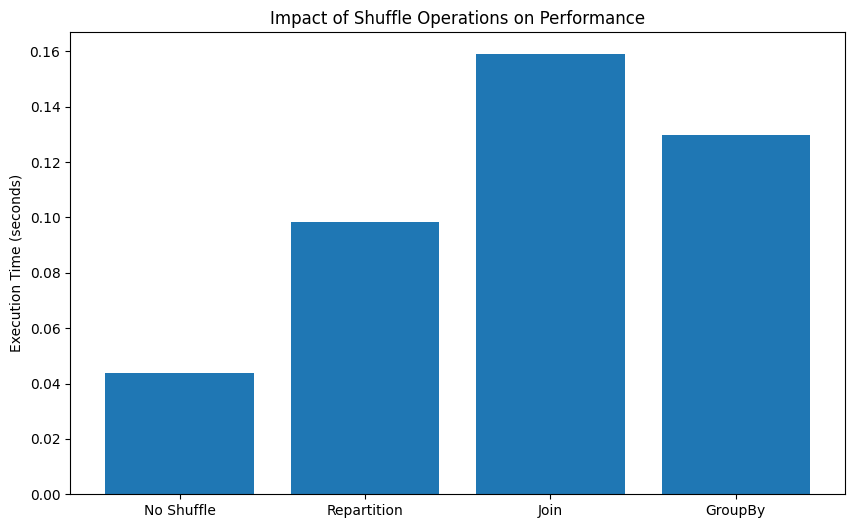

In [9]:
# Create datasets for shuffle demonstration
df1 = spark.range(0, 100000, 1, 4)  # 4 partitions
df2 = spark.range(0, 100000, 1, 8)  # 8 partitions

# Without shuffle (just a simple transformation)
start_time = time.time()
df1.select(col("id") * 2).count()
no_shuffle_time = time.time() - start_time
print(f"Operation without shuffle: {no_shuffle_time:.2f} seconds")

# With shuffle (repartitioning)
start_time = time.time()
df1.repartition(10).count()
repartition_time = time.time() - start_time
print(f"Repartition operation: {repartition_time:.2f} seconds")

# With shuffle (join operation)
start_time = time.time()
df1.join(df2, "id").count()
join_time = time.time() - start_time
print(f"Join operation: {join_time:.2f} seconds")

# With shuffle (groupBy operation)
start_time = time.time()
df1.groupBy(col("id") % 100).count().count()
group_time = time.time() - start_time
print(f"GroupBy operation: {group_time:.2f} seconds")

# Plot results
operations = ["No Shuffle", "Repartition", "Join", "GroupBy"]
times = [no_shuffle_time, repartition_time, join_time, group_time]

plt.figure(figsize=(10, 6))
plt.bar(operations, times)
plt.ylabel('Execution Time (seconds)')
plt.title('Impact of Shuffle Operations on Performance')
plt.show()

### The Shuffle Process

During a shuffle:

1. **Map phase**: Tasks in the "map" stage write shuffle data to local disk in shuffle files
2. **Shuffle service**: Handles transfer of shuffle data between executors
3. **Reduce phase**: Tasks in the "reduce" stage read shuffle data from multiple map outputs

```
Executor 1          Executor 2          Executor 3
+--------+          +--------+          +--------+
| Map 1  |          | Map 2  |          | Map 3  |
+--------+          +--------+          +--------+
     |                   |                   |
     v                   v                   v
+--------------------------SHUFFLE-------------------------+
     |                   |                   |
     v                   v                   v
+--------+          +--------+          +--------+
| Reduce1|          |Reduce2 |          |Reduce3 |
+--------+          +--------+          +--------+
```

### Partitioning Strategies

Efficient partitioning reduces shuffle overhead:

In [10]:
# Demonstrate partitioning strategies
# Create test data
data = [(i, f"user_{i}", i % 10) for i in range(1000)]
user_df = spark.createDataFrame(data, ["id", "name", "category"])

# Check default partitioning
print(f"Default partitioning: {user_df.rdd.getNumPartitions()} partitions")

# Repartition by key (for better join performance later)
partitioned_df = user_df.repartition(8, "category")
print(f"After repartitioning: {partitioned_df.rdd.getNumPartitions()} partitions")

# Examine distribution of data across partitions
from pyspark.sql.functions import spark_partition_id
partition_counts = partitioned_df.groupBy(spark_partition_id()).count()
print("\nDistribution of records across partitions:")
partition_counts.show()

# Demonstrate partitioning benefit for joins
# Create a small lookup table that shares the same key
category_lookup = spark.createDataFrame([(i, f"Category {i}") for i in range(10)], ["category", "description"])

# Join with partitioned data
start_time = time.time()
join_result = partitioned_df.join(category_lookup, "category")
join_result.count()
partitioned_join_time = time.time() - start_time
print(f"Join with partitioned data: {partitioned_join_time:.2f} seconds")

# Join with unpartitioned data
start_time = time.time()
join_result = user_df.join(category_lookup, "category")
join_result.count()
unpartitioned_join_time = time.time() - start_time
print(f"Join with unpartitioned data: {unpartitioned_join_time:.2f} seconds")

print(f"Improvement factor: {unpartitioned_join_time/partitioned_join_time:.2f}x")

Default partitioning: 4 partitions
After repartitioning: 8 partitions

Distribution of records across partitions:
+--------------------+-----+
|SPARK_PARTITION_ID()|count|
+--------------------+-----+
|                   0|  100|
|                   1|  100|
|                   3|  200|
|                   4|  300|
|                   5|  300|
+--------------------+-----+

Join with partitioned data: 0.18 seconds
Join with unpartitioned data: 0.15 seconds
Improvement factor: 0.83x


### Minimizing Shuffle Impact

Strategies to reduce shuffle overhead:

1. **Filter early**: Reduce data size before shuffling
2. **Broadcast joins**: Use broadcast joins for small tables
3. **Partition by join key**: Pre-partition data by frequently used join keys
4. **Control partition count**: `spark.sql.shuffle.partitions` (default 200)
5. **Use coalesce() instead of repartition()** when reducing partitions

Let's demonstrate a broadcast join:

In [11]:
from pyspark.sql.functions import broadcast

# Normal join
start_time = time.time()
normal_join = user_df.join(category_lookup, "category")
normal_join.count()
normal_join_time = time.time() - start_time
print(f"Normal join: {normal_join_time:.2f} seconds")

# With broadcast hint
start_time = time.time()
broadcast_join = user_df.join(broadcast(category_lookup), "category")
broadcast_join.count()
broadcast_join_time = time.time() - start_time
print(f"Broadcast join: {broadcast_join_time:.2f} seconds")

print(f"Improvement factor: {normal_join_time/broadcast_join_time:.2f}x")

# Look at execution plans
print("\nNormal Join Plan:")
normal_join.explain()

print("\nBroadcast Join Plan:")
broadcast_join.explain()

Normal join: 0.13 seconds
Broadcast join: 0.18 seconds
Improvement factor: 0.72x

Normal Join Plan:
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [category#713L, id#711L, name#712, description#738]
   +- SortMergeJoin [category#713L], [category#737L], Inner
      :- Sort [category#713L ASC NULLS FIRST], false, 0
      :  +- Exchange hashpartitioning(category#713L, 4), ENSURE_REQUIREMENTS, [plan_id=2223]
      :     +- Filter isnotnull(category#713L)
      :        +- Scan ExistingRDD[id#711L,name#712,category#713L]
      +- Sort [category#737L ASC NULLS FIRST], false, 0
         +- Exchange hashpartitioning(category#737L, 4), ENSURE_REQUIREMENTS, [plan_id=2224]
            +- Filter isnotnull(category#737L)
               +- Scan ExistingRDD[category#737L,description#738]



Broadcast Join Plan:
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [category#713L, id#711L, name#712, description#738]
   +- BroadcastHashJoin [category#713L], [category#73

## 7. Performance Tuning

Optimizing Spark performance involves tuning multiple aspects:

### 1. Data Serialization

Spark uses serialization for data transfer and storage. Options include:
- **Java Serialization**: Default but slower
- **Kryo Serialization**: Faster and more compact

In [12]:
# Check current serializer
serializer_conf = spark.conf.get("spark.serializer", "Not explicitly set")
print(f"Current serializer: {serializer_conf}")
print("To use Kryo serialization, configure:")
print("spark.serializer: org.apache.spark.serializer.KryoSerializer")

Current serializer: Not explicitly set
To use Kryo serialization, configure:
spark.serializer: org.apache.spark.serializer.KryoSerializer


### 2. Memory Tuning

Memory-related configurations to consider:

- **spark.memory.fraction**: Fraction of heap used for execution and storage (default 0.6)
- **spark.memory.storageFraction**: Amount of execution memory that can be claimed by storage (default 0.5)
- **spark.shuffle.file.buffer**: Size of in-memory buffer for shuffle outputs (default 32k)
- **spark.executor.memoryOverhead**: Additional non-heap memory per executor (default is max(384M, 0.1 * spark.executor.memory))


### 3. Execution Tuning

Execution-related configurations:

- **spark.default.parallelism**: Default number of partitions in RDDs
- **spark.sql.shuffle.partitions**: Number of partitions for shuffles in SQL queries (default 200)
- **spark.sql.autoBroadcastJoinThreshold**: Maximum size for broadcasts in joins (default 10M)
- **spark.sql.adaptive.enabled**: Enable adaptive query execution (default true in Spark 3.x)

Let's check some of these settings:

In [13]:
# Check execution-related configurations
execution_configs = [
    "spark.default.parallelism",
    "spark.sql.shuffle.partitions",
    "spark.sql.autoBroadcastJoinThreshold",
    "spark.sql.adaptive.enabled"
]

print("Execution Configuration:")
for config in execution_configs:
    try:
        value = spark.conf.get(config)
    except Exception:
        value = "Not explicitly set"
    print(f"{config}: {value}")
    
# Alternative approach - showing all configuration values containing 'broadcast'
print("\nBroadcast-related configurations:")
broadcast_configs = [item for item in sorted(spark.sparkContext.getConf().getAll()) 
                    if 'broadcast' in item[0].lower()]
for name, value in broadcast_configs:
    print(f"{name}: {value}")

Execution Configuration:
spark.default.parallelism: 4
spark.sql.shuffle.partitions: 4
spark.sql.autoBroadcastJoinThreshold: 10485760b
spark.sql.adaptive.enabled: true

Broadcast-related configurations:


### 4. Performance Monitoring

Tools for monitoring Spark performance:

1. **Spark UI**: Web interface showing job details (typically on port 4040)
2. **spark.eventLog.enabled**: Enable event logging
3. **Spark History Server**: For viewing historical application data

### 5. Key Performance Best Practices

Here's a summary of key performance optimization strategies:

1. **Optimize Data Input/Output**
   - Use columnar formats like Parquet
   - Filter early in your pipeline
   - Partition your data sources by commonly filtered columns

2. **Minimize Shuffling**
   - Use broadcast joins for small tables
   - Repartition by frequently joined keys
   - Try to place transformations requiring the same partitioning together

3. **Manage Resources Efficiently**
   - Set appropriate executor numbers and sizes
   - Tune memory allocation between storage and execution
   - Consider the right level of parallelism for your cluster

4. **Use Caching Strategically**
   - Cache datasets used multiple times
   - Choose the appropriate storage level
   - Unpersist when no longer needed

5. **Optimize Data Structure**
   - Use appropriate data types (e.g., avoid strings when numbers would work)
   - Consider using Kryo serialization for complex objects
   - Prune unnecessary columns early in your pipeline

## Conclusion

This notebook has covered the internal workings of PySpark, focusing on:

1. Spark's distributed architecture with drivers and executors
2. How executors and task slots enable parallel processing
3. Lazy execution and the optimization of execution plans
4. Memory management across storage and execution
5. The impact of shuffling and strategies to minimize it
6. Approaches to tune Spark for optimal performance

Understanding these internals helps you write more efficient Spark code, troubleshoot performance issues, and optimize your data processing pipelines.

In [14]:
# Clean up and stop the SparkSession
spark.stop()
print("SparkSession stopped.")

SparkSession stopped.
